In [2]:
import warnings
warnings.filterwarnings('ignore')

import os, sys, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.utils import shuffle

# Pytorch imports
import torch
print(f"Using Pytorch {torch.__version__}. GPU {' is available :)' if torch.cuda.is_available() else ' is not available :('}")

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchsummary import summary

# My helper functions for training/evaluating etc.
import pytorch_toolkit as pytk

Using Pytorch 1.7.1+cpu. GPU  is not available :(


In [4]:
# initialize random number generators
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

# tweaks for libraries
np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn')
sns.set(style='whitegrid', font_scale=1.1, palette='muted')

In [5]:
# some globals
DATA_FILE = os.path.join('.', 'csv_files', 'weatherAUS.csv')
print(f"Data file: {DATA_FILE}")
MODEL_SAVE_PATH = os.path.join('.', 'model_states', 'weather_model.pt')
print(f"MODEL_SAVE_PATH: {MODEL_SAVE_PATH}")

NUM_EPOCHS = 2500
BATCH_SIZE = 1024 * 3
LR = 0.001

Data file: ./csv_files/weatherAUS.csv
MODEL_SAVE_PATH: ./model_states/weather_model.pt


## Load the Data

In [20]:
# ---------------------------------------------------------------------------
# load data, select fields & apply scaling
# ---------------------------------------------------------------------------
def get_data(test_split=0.20, shuffle_it=True, balance=True, sampling_strategy=0.85, debug=False):
    from imblearn.over_sampling import SMOTE

    df = pd.read_csv(DATA_FILE)

    if shuffle_it:
        df = shuffle(df)

    cols = ['Rainfall', 'Humidity3pm',
            'Pressure9am', 'RainToday', 'RainTomorrow']
    df = df[cols]

    # convert categorical cols - RainToday & RainTomorrow to numeric
    df['RainToday'].replace({"No": 0, "Yes": 1}, inplace=True)
    df['RainTomorrow'].replace({"No": 0, "Yes": 1}, inplace=True)

    # drop all rows where any cols == Null
    df = df.dropna(how='any')
    
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    
    # display plot of target
    sns.countplot(df.RainTomorrow, ax=axs[0])
    axs[0].set_title("Existing counts")

    X = df.drop(['RainTomorrow'], axis=1).values
    y = df['RainTomorrow'].values
    if debug:
        print(f"{'Before balancing ' if balance else ''} X.shape = {X.shape}, "
              f"y.shape = {y.shape}, y-count = {np.bincount(y)}")

    if balance:
        ros = SMOTE(sampling_strategy=sampling_strategy, random_state=seed)
        X, y = ros.fit_resample(X, y)
        if debug:
            print(f"Resampled -> X.shape = {X.shape}, y.shape = {y.shape}, "
                  f"y-count = {np.bincount(y)}")

    # display plot of target
    sns.countplot(y, ax=axs[1])
    axs[1].set_title("After re-balancing")
    plt.suptitle("Chance of Rain Tomorrow")
    
    for ax in axs.flat:
        ax.set(xlabel='Rain Tomorrow', ylabel='Count')
        
    for ax in fig.get_axes():
        ax.label_outer()
    
    plt.show()

    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=test_split, random_state=seed)
    if debug:
        print(f"Split data -> X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}, "
              f"X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")

    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    # NOTE: BCELoss() expects labels to be floats - why???
    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')

    y_train = y_train[:, np.newaxis]
    y_test = y_test[:, np.newaxis]

    return (X_train, y_train), (X_test, y_test)

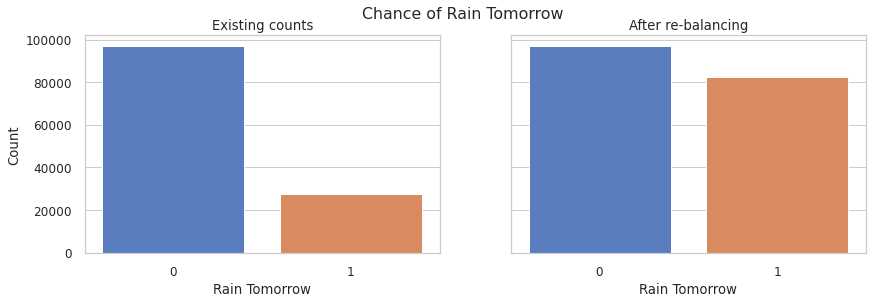

X_train.shape: (143712, 4) - y_train.shape: (143712, 1) - X_test.shape: (35928, 4) - y_test.shape: (35928, 1)


In [22]:
(X_train, y_train), (X_test, y_test) = get_data()
print(f"X_train.shape: {X_train.shape} - y_train.shape: {y_train.shape} - X_test.shape: {X_test.shape} - y_test.shape: {y_test.shape}") 

## Build the model

In [26]:
# our binary classification model
class Net(pytk.PytkModule):
    def __init__(self, features):
        super(Net, self).__init__()
        self.fc1 = pytk.Linear(features, 5)
        self.fc2 = pytk.Linear(5, 3)
        self.out = pytk.Linear(3, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.out(x))
        return x

In [27]:
model = Net(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
# optimizer = optim.SGD(model.parameters(), lr=LR)
model.compile(loss=criterion, optimizer=optimizer, metrics=['accuracy'])
print(model)

Net(
  (fc1): Linear(in_features=4, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=3, bias=True)
  (out): Linear(in_features=3, out_features=1, bias=True)
  (loss_fn): BCELoss()
)


In [28]:
hist = model.fit(X_train, y_train, validation_split=0.2, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                 report_interval=50, verbose=2)

Training on CPU...
Training on 114969 samples, cross-validating on 28743 samples
NOTE: training progress will be reported after every 50 epochs
Epoch (   1/2500): (114969/114969) -> loss: 0.6958 - accuracy: 0.4085 - val_loss: 0.6915 - val_accuracy: 0.4732 - lr: ['0.00100000']
Epoch (  50/2500): (114969/114969) -> loss: 0.4870 - accuracy: 0.7637 - val_loss: 0.4879 - val_accuracy: 0.7650 - lr: ['0.00100000']
Epoch ( 100/2500): (114969/114969) -> loss: 0.4862 - accuracy: 0.7638 - val_loss: 0.4870 - val_accuracy: 0.7655 - lr: ['0.00100000']
Epoch ( 150/2500): (114969/114969) -> loss: 0.4851 - accuracy: 0.7636 - val_loss: 0.4863 - val_accuracy: 0.7658 - lr: ['0.00100000']
Epoch ( 200/2500): (114969/114969) -> loss: 0.4840 - accuracy: 0.7647 - val_loss: 0.4854 - val_accuracy: 0.7666 - lr: ['0.00100000']
Epoch ( 250/2500): (114969/114969) -> loss: 0.4837 - accuracy: 0.7646 - val_loss: 0.4853 - val_accuracy: 0.7664 - lr: ['0.00100000']
Epoch ( 300/2500): (114969/114969) -> loss: 0.4839 - accur

KeyboardInterrupt: 

In [29]:
# display plots of loss & metric(s) used across epochs
pytk.show_plots(hist)

NameError: name 'hist' is not defined